# Creating a basic SPAM classifier

I did this project as an exercise for Chapter 3 of the book **HandsOn: Machine Learning with Scikit-Learn, Keras and TensorFlow**. The example data was extracted from a public dataset available at Apache Spam Assasin website, I found the CSV version (with a bit of preprocessing) at Kaggle. 

In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv('spam_or_not_spam.csv').dropna()

In [3]:
df.iloc[[10,30,2800,2900]]

,email,label
10,hello have you seen and discussed this article...,0
30,has anyone seen heard of used some package tha...,0
2800,free bonus offer see below we can supply top ...,1
2900,a great sponsor will not make you money a grea...,1


## 1 - Spliting train and test set

Spliting train set and test set in a stratified way to keep the proportion of spams

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

In [156]:
spl = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)

In [157]:
for train_idx, test_idx in spl.split(df, df['label']):
    df_train = df.iloc[train_idx].drop('label', axis=1)
    y_train = df.iloc[train_idx, 1]
    df_test = df.iloc[test_idx].drop('label',axis=1)
    y_test = df.iloc[test_idx, 1]

## 2 - Preparation pipeline


#### Creating a transformer which extracts all possible features from the train dataset and preprocesses it according to given parameters

In [70]:
from sklearn.base import TransformerMixin, BaseEstimator

In [140]:
from scipy.sparse import csr_matrix

In [213]:
class Get_Features(TransformerMixin, BaseEstimator):
    def __init__(self, case_insensitive=True, remove_ponctuation=True, count=False):
        self.case_insensitive=case_insensitive
        self.remove_ponctuation=remove_ponctuation
        self.count = count
    def process_email(self, email):
        em = set([i.strip() for i in email.split(' ') if i != ''])
        if self.case_insensitive:
            em = set(map(str.upper, em))
        if self.remove_ponctuation:
            pat = re.compile('(\.)|(/)|(\?)|(!)|(;)|(:)|(,)|(_)|(-)')
            em = set([re.sub(pat, '', i) for i in em])
        return em
    def fit(self, X, y=None):
        self.feat = sorted(list(set([i.strip() for i in (" ".join(X.values[:,0])).split(' ') if i != ''])))
        if self.case_insensitive:
            self.feat = sorted(list(set(map(str.upper, self.feat))))
        if self.remove_ponctuation:
            pat = re.compile('(\.)|(/)|(\?)|(!)|(;)|(:)|(,)|(_)|(-)')
            self.feat = sorted(list(set([re.sub(pat, '', i) for i in self.feat])))
        return self
    def transform(self, X, y=None):
        Xt = []
        for idx_email in range(len(X)):
            li = [0 for k in range(len(self.feat))]
            email_proc = self.process_email(X.values[idx_email,0])
            for idx_feature in range(len(self.feat)):
                if self.feat[idx_feature] in email_proc:
                    if self.count:
                        li[idx_feature] += 1
                    else:
                        li[idx_feature] = 1
            Xt.append(li)
        Xt = np.array(Xt)
        return csr_matrix(Xt)

## 3 - Testing some classifiers to choose which algorithm is better 

In [259]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score

**I'll try sixs different algorithms (SGD, KNeighbors, RandomForest, SVC, LogisticRegression) and choose the one with the highest Area Under the ROC Curve score**

In [166]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [144]:
from sklearn.pipeline import Pipeline

In [194]:
def evaluate_algorithms(algos, names, methods, x_train, y_train, cv=3, n_jobs=-1, **Transf_params):
    for algo, name,met in zip(algos, names,methods):
        pipe_full = Pipeline([
            ('Transf', Get_Features(**Transf_params)),
            ('Model', algo)
        ])
        prevs = cross_val_predict(pipe_full, x_train, y_train, cv=cv, n_jobs=n_jobs, method=met)
        print(name.center(30, '-'))
        print('Method: {}'.format(met))
        if met == 'decision_function':
            print('ROC_AUC_Score: {}'.format(roc_auc_score(y_train, prevs)))
        elif met == 'predict_proba':
            print('ROC_AUC_Score: {}'.format(roc_auc_score(y_train, prevs[:,1])))
        print('-'*30)

In [195]:
algos = [SGDClassifier(random_state=42), KNeighborsClassifier(), RandomForestClassifier(), LogisticRegression(random_state=42), SVC()]
names = ['SGD', 'KNeighbors', 'RandomForest', 'LogisticRegression', 'SVC']
methods = ['decision_function', 'predict_proba', 'predict_proba','decision_function', 'decision_function']

* **Counting each appearence (count=True)**

In [196]:
evaluate_algorithms(algos, names, methods,df_train, y_train, cv=4, n_jobs=-1, count=True)

-------------SGD--------------
Method: decision_function
ROC_AUC_Score: 0.9918333333333333
------------------------------
----------KNeighbors----------
Method: predict_proba
ROC_AUC_Score: 0.9142888471177945
------------------------------
---------RandomForest---------
Method: predict_proba
ROC_AUC_Score: 0.9938715538847117
------------------------------
------LogisticRegression------
Method: decision_function
ROC_AUC_Score: 0.9991115288220551
------------------------------
-------------SVC--------------
Method: decision_function
ROC_AUC_Score: 0.9965263157894737
------------------------------


* **Counting just one appearence (count=False)**

In [198]:
evaluate_algorithms(algos, names, methods, df_train, y_train, cv=4, n_jobs=-1, count=False)

-------------SGD--------------
Method: decision_function
ROC_AUC_Score: 0.9918333333333333
------------------------------
----------KNeighbors----------
Method: predict_proba
ROC_AUC_Score: 0.9142888471177945
------------------------------
---------RandomForest---------
Method: predict_proba
ROC_AUC_Score: 0.9938734335839599
------------------------------
------LogisticRegression------
Method: decision_function
ROC_AUC_Score: 0.9991115288220551
------------------------------
-------------SVC--------------
Method: decision_function
ROC_AUC_Score: 0.9965263157894737
------------------------------


**Logistic Regression seems to be the winer in either case. So once picked the classifier lets dive into hyperparameter tuning**

## 4 - Hyperparameter Tuning

In [202]:
from scipy.stats.distributions import expon, uniform

In [214]:
prep_predict = Pipeline([
    ('Transform', Get_Features()),
    ('Model', LogisticRegression(random_state=42, n_jobs=-1))
])

In [241]:
param_grid = {
    'Model__C':expon(1)
}

In [242]:
from sklearn.model_selection import RandomizedSearchCV

In [244]:
grid = RandomizedSearchCV(prep_predict, param_distributions=param_grid, n_iter=10, cv=3, verbose=10, scoring=['accuracy',
                                                                                                              'f1',
                                                                                                             'precision',
                                                                                                             'recall'],
                         refit='f1')

In [245]:
grid.fit(df_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START Model__C=2.7572940491693894................................
[CV 1/3; 1/10] END Model__C=2.7572940491693894; accuracy: (test=0.981) f1: (test=0.941) precision: (test=0.992) recall: (test=0.895) total time=  15.9s
[CV 2/3; 1/10] START Model__C=2.7572940491693894................................
[CV 2/3; 1/10] END Model__C=2.7572940491693894; accuracy: (test=0.985) f1: (test=0.954) precision: (test=0.976) recall: (test=0.932) total time=  17.1s
[CV 3/3; 1/10] START Model__C=2.7572940491693894................................
[CV 3/3; 1/10] END Model__C=2.7572940491693894; accuracy: (test=0.992) f1: (test=0.977) precision: (test=0.985) recall: (test=0.970) total time=  13.2s
[CV 1/3; 2/10] START Model__C=3.634032284001149.................................
[CV 1/3; 2/10] END Model__C=3.634032284001149; accuracy: (test=0.981) f1: (test=0.941) precision: (test=0.992) recall: (test=0.895) total time=  16.3s
[CV 2/3;

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('Transform', Get_Features()),
                                             ('Model',
                                              LogisticRegression(n_jobs=-1,
                                                                 random_state=42))]),
                   param_distributions={'Model__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019C1FD14130>},
                   refit='f1',
                   scoring=['accuracy', 'f1', 'precision', 'recall'],
                   verbose=10)

In [250]:
grid.best_score_

0.95851540315088

In [251]:
grid.best_params_

{'Model__C': 1.5488658058511535}

In [253]:
model = grid.best_estimator_

**The estimator with the highest f1_score (which is the harmonic mean of the precision and recall) will be the chosen one**

*Obs: Very little hyperparameter tuning was performed, it is possible to find better parameters with time and computational power*

## 5 - Testing the model on the test dataset

### 5.1 - Metrics

In [262]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve,f1_score, confusion_matrix

In [263]:
prevs = model.predict(df_test)

In [264]:
prevs_scores = model.decision_function(df_test)

#### 5.1.1 - Accuracy

In [256]:
np.mean(prevs == y_test)

0.99

Let's compare with a dummy model which always classifies emails as not spam (Most of the dataset is not spam)

In [257]:
np.mean(0 == y_test)

0.8333333333333334

The model shows a great improvment from the dummy model

#### 5.1.2 - Confusion Matrix

In [265]:
confusion_matrix(y_test, prevs)

array([[500,   0],
       [  6,  94]], dtype=int64)

#### 5.1.3 - Precision

In [267]:
precision_score(y_test, prevs)

1.0

#### 5.1.3 - Recall

In [268]:
recall_score(y_test, prevs)

0.94

#### 5.1.4 - F1 Score

In [269]:
f1_score(y_test, prevs)

0.9690721649484536

#### 5.1.5 - ROC AUC (Area Under ROC Curve)

In [270]:
roc_auc_score(y_test, prevs_scores)

0.99954

### 5.2 - Curves

In [275]:
precision, recall, threshold = precision_recall_curve(y_test, prevs_scores)

Text(0.5, 1.0, 'Precision and Recall X Threshold')

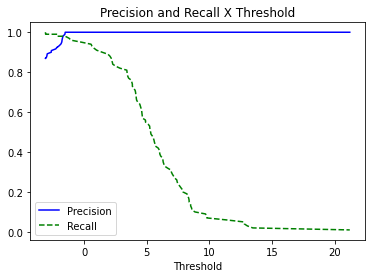

In [287]:
plt.plot(threshold, precision[:-1], 'b-', label='Precision')
plt.plot(threshold, recall[:-1],'g--', label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision and Recall X Threshold')

Text(0.5, 1.0, 'Recall X Precision')

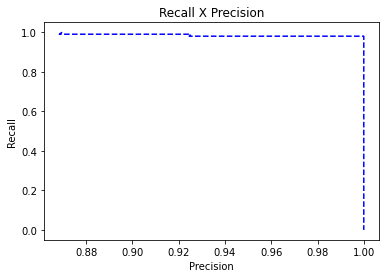

In [293]:
plt.plot(precision, recall, 'b--')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Recall X Precision')

In [294]:
fpr, tpr, threshold = roc_curve(y_test, prevs_scores)

Text(0.5, 1.0, 'ROC Curve')

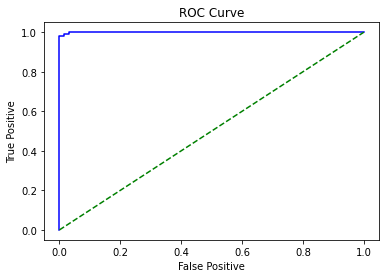

In [297]:
plt.plot(fpr, tpr, 'b-')
plt.plot([0,1],[0,1], 'g--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')

## 6 - Summary and Conclusion

* LogisticRegression model with very little hyperparameter tuning:
    + Accuracy: 0.99
    + Precision: 1.0
    + Recall: 0.94
    + F1 Score: 0.9690


The model seems to have performed well. However it is important to notice that in a SPAM classifing system Recall is more important than Precision, because if a user believes an email is not a SPAM when in fact it is, he could be susceptible to a fishing attack or something like that. So it is more important to increase Recall even though the user might get some false positives (Reduced precision). Safety is the main goal.

Analysing the confusion matrix and curves it is possible to pick a threshold that will assure almost 100% recall with over 82% precision, that is what we are looking for.

## 7 - What is next, possible improvements

* Better preprocessing (Regular expressions for example)
* Better hyperparameter tuning
* Use stratified sampling on cross validation to pick the best model